# Modern Hopfield Network (MHN) とTransformer の比較

> **目的**: 同じattention式を持つA:MHNとB:Transformerについて、GeneralizationとSample recallの2軸で比較
> 
> **条件**:
> - ε = 0.1（デノイズ、固定）
> - A: β = [0.1, 0.3, 0.5]（MHNの想起の鋭さのパラメータ、固定値）
> - B: β学習で調整
> - C = [4, 8, 16]（クラス数）

In [14]:
# === ログ & 図保存ユーティリティ ===
import os, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

OUT_DIR = "out"
os.makedirs(OUT_DIR, exist_ok=True)

def log_record(record: dict, csv_path=f"{OUT_DIR}/records.csv"):
    """1実験ぶんの指標をCSVに追記（存在しなければヘッダ付きで新規作成）。"""
    df = pd.DataFrame([record])
    header = not os.path.exists(csv_path)
    df.to_csv(csv_path, mode="a", header=header, index=False)

def savefig_fig(fig, name: str, out_dir=OUT_DIR):
    """Matplotlib Figure をPNG保存（dpiと余白は論文/ES向け）。"""
    os.makedirs(out_dir, exist_ok=True)
    fig.savefig(os.path.join(out_dir, f"{name}.png"), dpi=200, bbox_inches="tight")

def tag(variant, alpha, beta, eps, seed=None):
    """ファイル名タグを統一（再現性のための命名規則）。"""
    s = f"{variant}_a{alpha:.3f}_b{beta:.3f}_e{eps:.3f}"
    if seed is not None:
        s += f"_seed{seed}"
    return s


In [15]:
# === セル1: 基本セットアップ ===
import os, math, time, random, json
from dataclasses import dataclass
from collections import defaultdict
from typing import Dict, List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE)

Device: cpu


In [16]:
# === セル2: 実験パラメータ ===
@dataclass
class Config:
    N: int = 32
    d_model: int = 16
    batch: int = 16
    steps: int = 800
    lr: float = 1e-3
    weight_decay: float = 1e-5
    epsilon: float = 0.1  # 固定
    ffn_mult: int = 4
    lambda_ortho: float = 1e-3
    lambda_entropy: float = 0.1
    beta_transformer: float = 2.0  # B用初期値
    rho_intra: float = 0.2

CFG = Config()

# 実験変数
BETAS = [0.1, 0.3, 0.5]      # A用β値
CLASS_NUMS = [4, 8, 16]      # クラス数
ALPHAS = [1, 5, 10, 20, 50]  # α値
SEEDS = [0, 1, 2, 3, 4]      # シード

print(f"実験条件:")
print(f"  A β値: {BETAS}")
print(f"  クラス数: {CLASS_NUMS}")
print(f"  α値: {ALPHAS}")
print(f"  シード数: {len(SEEDS)}")

実験条件:
  A β値: [0.1, 0.3, 0.5]
  クラス数: [4, 8, 16]
  α値: [1, 5, 10, 20, 50]
  シード数: 5


In [17]:
# === セル3: データ生成 ===
class PrototypeMemoryBank:
    def __init__(self, N: int, C: int, P_total: int, rho_intra: float, seed: int = 0):
        set_seed(seed)
        self.N = N
        self.C = C
        self.P_total = P_total
        self.rho_intra = rho_intra
        
        # クラス原型（±1）
        self.proto = torch.randint(0, 2, (C, N)) * 2 - 1
        self.proto = self.proto.float()
        
        # P_total をクラスに均等配分
        counts = [P_total // C] * C
        for i in range(P_total % C):
            counts[i] += 1

        ys, xs = [], []
        for c in range(C):
            for _ in range(counts[c]):
                base = self.proto[c].clone()
                flip = (torch.rand(N) < self.rho_intra).float()
                x = base * (1.0 - 2.0 * flip)
                xs.append(x)
                ys.append(c)

        if len(xs) == 0:
            raise ValueError("P_total must be >= 1")

        self.train_X = torch.stack(xs)
        self.train_y = torch.tensor(ys, dtype=torch.long)
        self.P = self.train_X.shape[0]

    def sample_noisy_batch(self, B: int, epsilon: float):
        idx = torch.randint(0, self.P, (B,))
        clean = self.train_X[idx]
        y = self.train_y[idx]
        flip = (torch.rand_like(clean) < epsilon).float()
        noisy = clean * (1.0 - 2.0 * flip)
        return noisy, clean, y

    def sample_unseen_clean(self, B: int):
        xs, ys = [], []
        per_class = max(1, B // self.C)
        for c in range(self.C):
            for _ in range(per_class):
                base = self.proto[c].clone()
                flip = (torch.rand(self.N) < self.rho_intra).float()
                x = base * (1.0 - 2.0 * flip)
                xs.append(x)
                ys.append(c)
        X = torch.stack(xs)[:B]
        Y = torch.tensor(ys[:B], dtype=torch.long)
        return X, Y

# ユーティリティ関数
def bce_from_pm1_logits(logits, target_pm1):
    target01 = (target_pm1 + 1.0) * 0.5
    return F.binary_cross_entropy_with_logits(logits, target01)

@torch.no_grad()
def overlap_pm1(a_pm1, b_pm1):
    return float((a_pm1 * b_pm1).mean().item())

@torch.no_grad()
def overlap_from_logits(logits, target_pm1):
    pred_pm1 = torch.sign(torch.tanh(logits))
    return overlap_pm1(pred_pm1, target_pm1)

@torch.no_grad()
def binarize_from_logits(logits):
    return torch.sign(torch.tanh(logits))

In [18]:
# === セル4: モデル定義 ===
class TrainingSampleMemoryModel(nn.Module):
    """モデルA: β固定の記憶ベースモデル"""
    def __init__(self, N: int, training_samples: torch.Tensor, C: int, beta: float):
        super().__init__()
        self.N = N
        self.C = C
        self.beta = beta
        self.register_buffer('training_samples', training_samples.clone())

    def forward(self, x_pm1):
        similarities = torch.matmul(x_pm1, self.training_samples.t())
        scaled_similarities = similarities * self.beta
        attn_weights = F.softmax(scaled_similarities, dim=-1)
        logits = torch.matmul(attn_weights, self.training_samples)
        return logits, {'attn': attn_weights}

class TransformerHopfieldModel(nn.Module):
    """モデルB: β学習のTransformerベースモデル"""
    def __init__(self, N: int, d_model: int, C: int, ffn_mult: int = 4, beta_init: float = 2.0):
        super().__init__()
        self.N = N
        self.C = C
        self.d_model = d_model
        
        self.enc = nn.Linear(N, d_model, bias=False)
        self.dec = nn.Linear(d_model, N, bias=False)
        self.beta = nn.Parameter(torch.tensor(beta_init))
        
        self.K = nn.Parameter(torch.randn(C, d_model) / math.sqrt(d_model))
        self.V = nn.Parameter(torch.randn(C, d_model) / math.sqrt(d_model))
        self.class_proto = nn.Parameter(torch.randn(C, d_model) / math.sqrt(d_model))
        
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ffn_mult * d_model),
            nn.ReLU(),
            nn.Linear(ffn_mult * d_model, d_model)
        )
        
    def forward(self, x_pm1):
        h = self.enc(x_pm1)
        
        score_mem = torch.matmul(h, self.K.t()) * self.beta
        attn_mem = F.softmax(score_mem, dim=-1)
        mem_out = torch.matmul(attn_mem, self.V)
        
        score_cls = torch.matmul(h, self.class_proto.t()) * self.beta
        attn_cls = F.softmax(score_cls, dim=-1)
        cls_out = torch.matmul(attn_cls, self.class_proto)
        
        out = h + mem_out + cls_out
        out = self.ffn(out)
        logits = self.dec(out)
        
        return logits, {'attn_mem': attn_mem, 'attn_cls': attn_cls}

def ortho_reg(K):
    G = F.normalize(K, dim=-1) @ F.normalize(K, dim=-1).t()
    return (G**2).sum() - torch.diag(G**2).sum()

In [19]:
# === セル5: 学習・評価関数 ===
def train_one_run(alpha, beta_A, seed, variant, C, cfg):
    set_seed(seed)
    N = cfg.N
    P = max(1, int(round(alpha * N)))
    
    bank = PrototypeMemoryBank(N=N, C=C, P_total=P, rho_intra=cfg.rho_intra, seed=seed)
    
    if variant == 'A':
        model = TrainingSampleMemoryModel(
            N=N, training_samples=bank.train_X, C=C, beta=beta_A
        ).to(DEVICE)
        
        # 疑似学習（何もしない）
        for step in range(1, cfg.steps+1):
            pass
        
        final_beta = beta_A
        
    elif variant == 'B':
        model = TransformerHopfieldModel(
            N=N, d_model=cfg.d_model, C=C,
            ffn_mult=cfg.ffn_mult, beta_init=cfg.beta_transformer
        ).to(DEVICE)
        opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
        
        # 学習ループ
        for step in range(1, cfg.steps+1):
            noisy, clean, y = bank.sample_noisy_batch(cfg.batch, cfg.epsilon)
            noisy = noisy.to(DEVICE)
            clean = clean.to(DEVICE)
            y_dev = y.to(DEVICE)
            
            logits, aux = model(noisy)
            
            loss_rec = bce_from_pm1_logits(logits, clean)
            attn = aux['attn_mem']
            entropy = -(attn * (attn.clamp_min(1e-9)).log()).sum(-1).mean()
            loss = loss_rec - cfg.lambda_entropy * entropy + cfg.lambda_ortho * ortho_reg(model.K)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        final_beta = float(model.beta.item())
    
    else:
        raise ValueError('variant must be A or B')
    
    # === 2軸評価 ===
    # 1) Sample recall
    noisy, clean, y = bank.sample_noisy_batch(cfg.batch, cfg.epsilon)
    noisy = noisy.to(DEVICE)
    clean = clean.to(DEVICE)
    logits, _ = model(noisy)
    sample_recall_score = overlap_from_logits(logits, clean)
    
    # 2) Generalization
    X_unseen, Y_unseen = bank.sample_unseen_clean(cfg.batch)
    flip = (torch.rand_like(X_unseen) < cfg.epsilon).float()
    X_unseen_noisy = X_unseen * (1.0 - 2.0 * flip)
    logits_u, _ = model(X_unseen_noisy.to(DEVICE))
    
    with torch.no_grad():
        pred_u = binarize_from_logits(logits_u)
        proto = bank.proto.to(DEVICE)
        proto_u = proto[Y_unseen.to(DEVICE)]
        generalization_score = overlap_pm1(pred_u, proto_u)
    
    return {
        'alpha': float(alpha),
        'beta': float(final_beta),
        'seed': int(seed),
        'variant': variant,
        'C': int(C),
        'P': int(bank.P),
        'generalization_score': float(generalization_score),
        'sample_recall_score': float(sample_recall_score),
    }

In [20]:
# === セル6: 実験実行 ===
records = []

print("実験開始...")
total_A = len(BETAS) * len(CLASS_NUMS) * len(ALPHAS) * len(SEEDS)
total_B = len(CLASS_NUMS) * len(ALPHAS) * len(SEEDS)
total_runs = total_A + total_B
current_run = 0

for C in CLASS_NUMS:
    for alpha in ALPHAS:
        for seed in SEEDS:
            # モデルA: 各β値で実験
            for beta in BETAS:
                current_run += 1
                print(f"[{current_run}/{total_runs}] A: C={C} β={beta} α={alpha} seed={seed}")
                
                try:
                    rec = train_one_run(
                        alpha=alpha, beta_A=beta, seed=seed, 
                        variant='A', C=C, cfg=CFG
                    )
                    print(f"  → Gen: {rec['generalization_score']:.3f}, Recall: {rec['sample_recall_score']:.3f}")
                    records.append(rec)
                except Exception as e:
                    print(f"  ERROR: {e}")
            
            # モデルB: β学習
            current_run += 1
            print(f"[{current_run}/{total_runs}] B: C={C} α={alpha} seed={seed}")
            
            try:
                rec = train_one_run(
                    alpha=alpha, beta_A=None, seed=seed,
                    variant='B', C=C, cfg=CFG
                )
                print(f"  → Gen: {rec['generalization_score']:.3f}, Recall: {rec['sample_recall_score']:.3f}, β: {rec['beta']:.3f}")
                records.append(rec)
            except Exception as e:
                print(f"  ERROR: {e}")

            log_record(rec) 

print(f"\\n実験完了! 総記録数: {len(records)}")

実験開始...
[1/300] A: C=4 β=0.1 α=1 seed=0
  → Gen: 0.656, Recall: 0.746
[2/300] A: C=4 β=0.3 α=1 seed=0
  → Gen: 0.691, Recall: 1.000
[3/300] A: C=4 β=0.5 α=1 seed=0
  → Gen: 0.668, Recall: 1.000
[4/300] B: C=4 α=1 seed=0
  → Gen: 0.629, Recall: 0.844, β: 1.920
[5/300] A: C=4 β=0.1 α=1 seed=1
  → Gen: 0.664, Recall: 0.836
[6/300] A: C=4 β=0.3 α=1 seed=1
  → Gen: 0.727, Recall: 0.988
[7/300] A: C=4 β=0.5 α=1 seed=1
  → Gen: 0.684, Recall: 1.000
[8/300] B: C=4 α=1 seed=1
  → Gen: 0.715, Recall: 0.859, β: 1.931
[9/300] A: C=4 β=0.1 α=1 seed=2
  → Gen: 0.648, Recall: 0.828
[10/300] A: C=4 β=0.3 α=1 seed=2
  → Gen: 0.574, Recall: 1.000
[11/300] A: C=4 β=0.5 α=1 seed=2
  → Gen: 0.543, Recall: 1.000
[12/300] B: C=4 α=1 seed=2
  → Gen: 0.742, Recall: 0.820, β: 1.882
[13/300] A: C=4 β=0.1 α=1 seed=3
  → Gen: 0.742, Recall: 0.848
[14/300] A: C=4 β=0.3 α=1 seed=3
  → Gen: 0.773, Recall: 1.000
[15/300] A: C=4 β=0.5 α=1 seed=3
  → Gen: 0.695, Recall: 1.000
[16/300] B: C=4 α=1 seed=3
  → Gen: 0.602, R

性能曲線プロット:
\n2軸比較プロット:


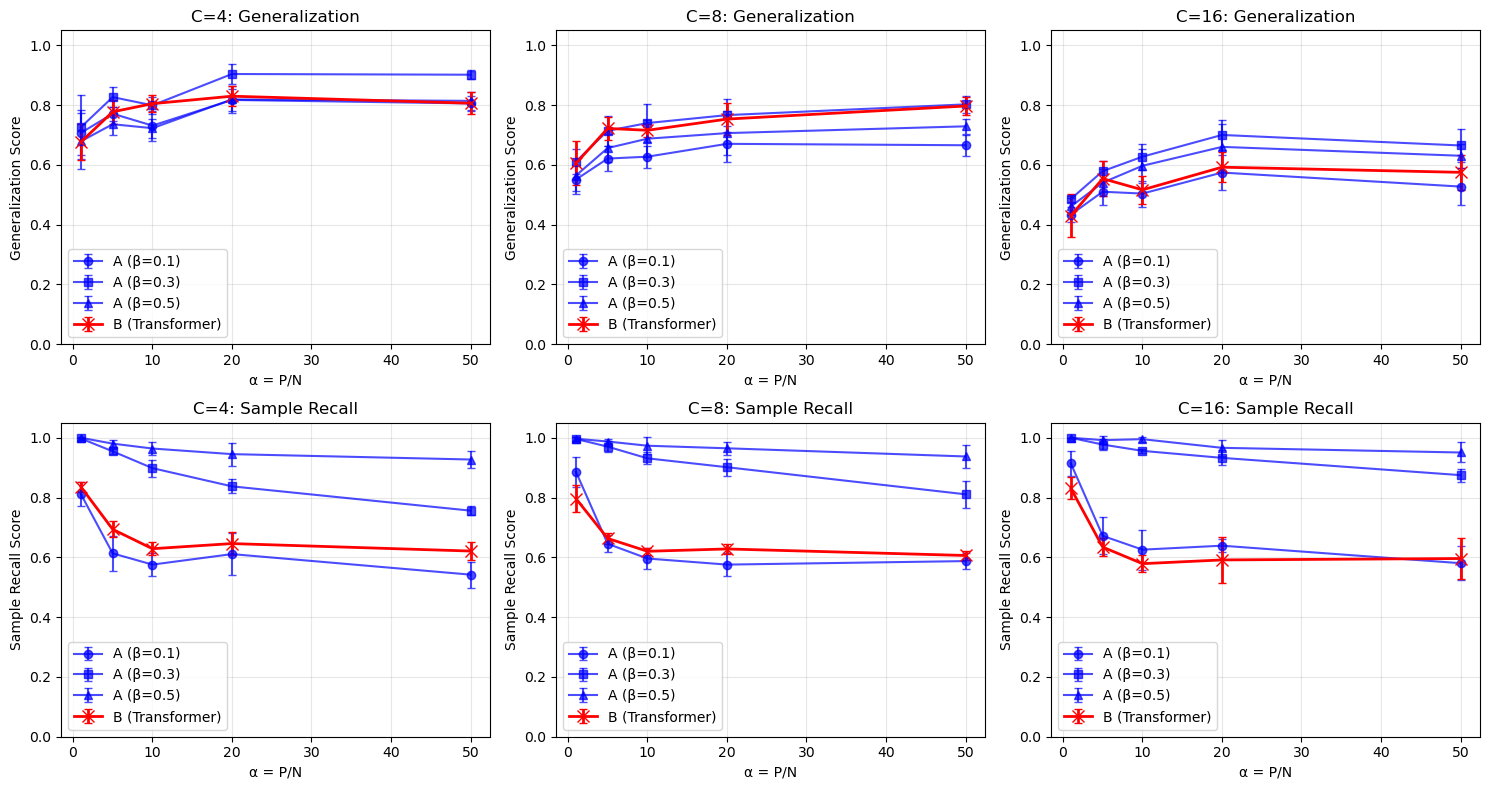

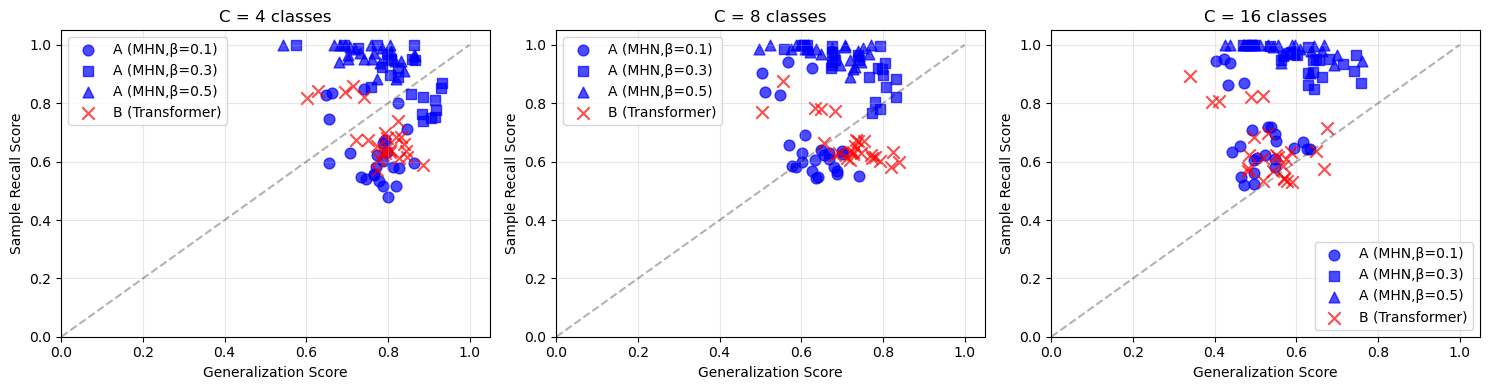

In [23]:
# === セル7: 可視化 ===
def plot_performance_curves(records,return_fig=True):
    # 性能曲線プロット（Generalization & Sample Recall）
    if not records:
        print("No data to plot!")
        return
        
    import pandas as pd
    df = pd.DataFrame(records)
    
    class_nums = sorted(df['C'].unique())
    metrics = ['generalization_score', 'sample_recall_score']
    metric_names = ['Generalization', 'Sample Recall']
    
    fig, axes = plt.subplots(2, len(class_nums), figsize=(5*len(class_nums), 8))
    if len(class_nums) == 1:
        axes = axes.reshape(-1, 1)
    
    colors = {'A': 'blue', 'B': 'red'}
    markers = {0.1: 'o', 0.3: 's', 0.5: '^'}
    
    for i, C in enumerate(class_nums):
        df_c = df[df['C'] == C]
        
        for j, (metric, name) in enumerate(zip(metrics, metric_names)):
            ax = axes[j, i]
            
            # モデルA: β値ごと
            df_a = df_c[df_c['variant'] == 'A']
            for beta in BETAS:
                df_ab = df_a[abs(df_a['beta'] - beta) < 0.01]  # 浮動小数点誤差対策
                if len(df_ab) > 0:
                    grouped = df_ab.groupby('alpha')[metric]
                    means = grouped.mean()
                    stds = grouped.std()
                    ax.errorbar(means.index, means.values, yerr=stds.values, 
                               marker=markers[beta], capsize=3, 
                               label=f'A (β={beta})', color=colors['A'], alpha=0.7)
            
            # モデルB
            df_b = df_c[df_c['variant'] == 'B']
            if len(df_b) > 0:
                grouped = df_b.groupby('alpha')[metric]
                means = grouped.mean()
                stds = grouped.std()
                ax.errorbar(means.index, means.values, yerr=stds.values,
                           marker='x', capsize=3, label='B (Transformer)', 
                           color=colors['B'], linewidth=2, markersize=8)
            
            ax.set_xlabel('α = P/N')
            ax.set_ylabel(f'{name} Score')
            ax.set_title(f'C={C}: {name}')
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.set_ylim(0.0, 1.05)
    
    plt.tight_layout()
    if return_fig:
        return fig
    else:
        plt.show() 


def plot_2d_comparison(records,return_fig=True):
    # 2軸比較プロット
    if not records:
        print("No data to plot!")
        return
        
    import pandas as pd
    df = pd.DataFrame(records)
    
    class_nums = sorted(df['C'].unique())
    
    fig, axes = plt.subplots(1, len(class_nums), figsize=(5*len(class_nums), 4))
    if len(class_nums) == 1:
        axes = [axes]
    
    colors = {'A': 'blue', 'B': 'red'}
    markers = {0.1: 'o', 0.3: 's', 0.5: '^'}
    
    for i, C in enumerate(class_nums):
        ax = axes[i]
        df_c = df[df['C'] == C]
        
        # モデルA: β値ごと
        df_a = df_c[df_c['variant'] == 'A']
        for beta in BETAS:
            df_ab = df_a[abs(df_a['beta'] - beta) < 0.01]
            if len(df_ab) > 0:
                ax.scatter(df_ab['generalization_score'], df_ab['sample_recall_score'], 
                          c=colors['A'], marker=markers[beta], s=60,
                          label=f'A (MHN,β={beta})', alpha=0.7)
        
        # モデルB
        df_b = df_c[df_c['variant'] == 'B']
        if len(df_b) > 0:
            ax.scatter(df_b['generalization_score'], df_b['sample_recall_score'],
                      c=colors['B'], marker='x', s=80,
                      label='B (Transformer)', alpha=0.7)
        
        ax.set_xlabel('Generalization Score')
        ax.set_ylabel('Sample Recall Score')
        ax.set_title(f'C = {C} classes')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_xlim(0.0, 1.05)
        ax.set_ylim(0.0, 1.05)
        
        # 対角線
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    
    plt.tight_layout()
    if return_fig:
        return fig
    else:
        plt.show() 

# 可視化実行
print("性能曲線プロット:")
plot_performance_curves(records)

print("\\n2軸比較プロット:")
plot_2d_comparison(records)

fig1 = plot_performance_curves(records, return_fig=True)
savefig_fig(fig1, "summary_perf")
plt.close(fig1)

fig2 = plot_2d_comparison(records, return_fig=True)
savefig_fig(fig2, "summary_2d")
plt.close(fig2)

In [ ]:
def analyze_nearest_training_overlap():
    """
    α=20の時の未知データと最も近い訓練データのオーバーラップを分析
    - 初期状態（ノイズ前）
    - 更新後（ノイズ後）
    """
    set_seed(42)
    N = 32
    C = 4
    alpha = 20  # 固定
    P = int(alpha * N)  # P = 640
    rho_intra = 0.2
    epsilon = 0.1

    bank = PrototypeMemoryBank(N=N, C=C, P_total=P,rho_intra=rho_intra, seed=42)

    print(f"=== α={alpha} (P={P}) での分析 ===")

    # 未知データ生成（ノイズ前）
    X_unseen_clean, Y_unseen = bank.sample_unseen_clean(16)

    # ノイズ追加（更新後）
    flip = (torch.rand_like(X_unseen_clean) <epsilon).float()
    X_unseen_noisy = X_unseen_clean * (1.0 - 2.0 * flip)

    print(f"ノイズレベル ε = {epsilon}")
    print(f"訓練サンプル数 P = {bank.P}")
    print()

    initial_max_overlaps = []
    updated_max_overlaps = []

    for i in range(len(X_unseen_clean)):
        unseen_clean = X_unseen_clean[i]  # 初期状態
        unseen_noisy = X_unseen_noisy[i]  # 更新後
        unseen_class = Y_unseen[i].item()

        # 初期状態：全訓練データとのオーバーラップ計算
        overlaps_clean =torch.matmul(unseen_clean.unsqueeze(0), bank.train_X.t()) / N
        overlaps_clean = overlaps_clean.squeeze(0)
        max_overlap_clean, max_idx_clean =overlaps_clean.max(dim=0)
        max_train_class_clean =bank.train_y[max_idx_clean].item()

        # 更新後：全訓練データとのオーバーラップ計算  
        overlaps_noisy =torch.matmul(unseen_noisy.unsqueeze(0), bank.train_X.t()) / N
        overlaps_noisy = overlaps_noisy.squeeze(0)
        max_overlap_noisy, max_idx_noisy =overlaps_noisy.max(dim=0)
        max_train_class_noisy =bank.train_y[max_idx_noisy].item()

        initial_max_overlaps.append(max_overlap_clean.item())
        updated_max_overlaps.append(max_overlap_noisy.item())

        print(f"未知サンプル{i} (クラス{unseen_class}):")
        print(f"  初期オーバーラップ: {max_overlap_clean.item():.3f} (訓練{max_idx_clean}, クラス{max_train_class_clean})")
        print(f"  更新後オーバーラップ: {max_overlap_noisy.item():.3f} (訓練{max_idx_noisy}, クラス{max_train_class_noisy})")
        print(f"  オーバーラップ変化: {max_overlap_noisy.item() - max_overlap_clean.item():+.3f}")

        # 同じクラス内での最大オーバーラップ
        same_class_mask = (bank.train_y == unseen_class)
        if same_class_mask.sum() > 0:
            same_class_clean =overlaps_clean[same_class_mask].max().item()
            same_class_noisy =overlaps_noisy[same_class_mask].max().item()
            print(f"  同クラス内最大: 初期{same_class_clean:.3f} → 更新後{same_class_noisy:.3f}")
        print()

    print("=== 全体統計 ===")
    print(f"初期最大オーバーラップ: 平均={np.mean(initial_max_overlaps):.3f}, 最大={np.max(initial_max_overlaps):.3f}")
    print(f"更新後最大オーバーラップ: 平均={np.mean(updated_max_overlaps):.3f}, 最大={np.max(updated_max_overlaps):.3f}")
    print(f"平均変化量: {np.mean(updated_max_overlaps) - np.mean(initial_max_overlaps):+.3f}")

    return initial_max_overlaps, updated_max_overlaps

# 実行
initial_overlaps, updated_overlaps =analyze_nearest_training_overlap()

=== α=20 (P=640) での分析 ===
ノイズレベル ε = 0.1
訓練サンプル数 P = 640

未知サンプル0 (クラス0):
  初期オーバーラップ: 0.812 (訓練138, クラス0)
  更新後オーバーラップ: 0.875 (訓練138, クラス0)
  オーバーラップ変化: +0.062
  同クラス内最大: 初期0.812 → 更新後0.875

未知サンプル1 (クラス0):
  初期オーバーラップ: 0.750 (訓練44, クラス0)
  更新後オーバーラップ: 0.750 (訓練73, クラス0)
  オーバーラップ変化: +0.000
  同クラス内最大: 初期0.750 → 更新後0.750

未知サンプル2 (クラス0):
  初期オーバーラップ: 0.688 (訓練61, クラス0)
  更新後オーバーラップ: 0.625 (訓練88, クラス0)
  オーバーラップ変化: -0.062
  同クラス内最大: 初期0.688 → 更新後0.625

未知サンプル3 (クラス0):
  初期オーバーラップ: 0.688 (訓練44, クラス0)
  更新後オーバーラップ: 0.562 (訓練11, クラス0)
  オーバーラップ変化: -0.125
  同クラス内最大: 初期0.688 → 更新後0.562

未知サンプル4 (クラス1):
  初期オーバーラップ: 0.812 (訓練180, クラス1)
  更新後オーバーラップ: 0.812 (訓練222, クラス1)
  オーバーラップ変化: +0.000
  同クラス内最大: 初期0.812 → 更新後0.812

未知サンプル5 (クラス1):
  初期オーバーラップ: 0.875 (訓練196, クラス1)
  更新後オーバーラップ: 0.875 (訓練185, クラス1)
  オーバーラップ変化: +0.000
  同クラス内最大: 初期0.875 → 更新後0.875

未知サンプル6 (クラス1):
  初期オーバーラップ: 0.562 (訓練289, クラス1)
  更新後オーバーラップ: 0.500 (訓練189, クラス1)
  オーバーラップ変化: -0.062
  同クラス内最大: 初期0.562 → 更新後0.500

未知サンプル7 (ク

In [ ]:
def compare_overlap_vs_generalization():
    """
    未知データ→訓練データの最大オーバーラップ vs Generalizationスコアの比較
    Aが真の汎化をしているか、単なる記憶検索かを検証
    """
    set_seed(42)
    N = 32
    C = 4
    alpha = 20
    P = int(alpha * N)  # P = 640
    rho_intra = 0.2
    epsilon = 0.1
    beta = 0.3  # モデルA用

    bank = PrototypeMemoryBank(N=N, C=C, P_total=P,rho_intra=rho_intra, seed=42)
    model_A = TrainingSampleMemoryModel(N=N,training_samples=bank.train_X, C=C, beta=beta)

    print(f"=== 記憶 vs 汎化の比較分析 (α={alpha}, β={beta}) ===")

    # 未知データ生成
    X_unseen_clean, Y_unseen = bank.sample_unseen_clean(16)
    flip = (torch.rand_like(X_unseen_clean) <epsilon).float()
    X_unseen_noisy = X_unseen_clean * (1.0 - 2.0 * flip)

    max_overlaps = []
    generalization_scores = []

    with torch.no_grad():
        for i in range(len(X_unseen_noisy)):
            unseen_noisy = X_unseen_noisy[i:i+1]  # (1, N)
            unseen_class = Y_unseen[i].item()

            # 1) 最大オーバーラップ: 未知データ → 訓練データ
            overlaps = torch.matmul(unseen_noisy,bank.train_X.t()) / N  # (1, P)
            max_overlap = overlaps.max().item()
            max_overlaps.append(max_overlap)

            # 2) Generalizationスコア: 復元結果 → プロトタイプ
            restored, _ = model_A(unseen_noisy)  # (1, N)
            restored_binary =torch.sign(torch.tanh(restored))  # ±1に変換
            prototype =bank.proto[unseen_class:unseen_class+1]  # (1, N)
            gen_score = (restored_binary *prototype).mean().item()
            generalization_scores.append(gen_score)

            print(f"サンプル{i} (クラス{unseen_class}):")
            print(f"  最大オーバーラップ:      {max_overlap:.3f}")
            print(f"  Generalizationスコア:  {gen_score:.3f}")
            print(f"  差 (Gen - MaxOverlap):  {gen_score - max_overlap:+.3f}")

            if gen_score > max_overlap:
                print("  → 真の汎化の可能性!")
            else:
                print("  → 記憶ベースの可能性")
            print()

    # 全体統計
    avg_max_overlap = np.mean(max_overlaps)
    avg_generalization = np.mean(generalization_scores)

    print("=== 全体結果 ===")
    print(f"平均最大オーバーラップ:     {avg_max_overlap:.3f}")
    print(f"平均Generalizationスコア:  {avg_generalization:.3f}")
    print(f"平均差 (Gen - MaxOverlap):  {avg_generalization -avg_max_overlap:+.3f}")
    print()

    if avg_generalization > avg_max_overlap:
        print("🎯 結論: モデルAは単純な記憶検索を**超えた汎化**を示している！")
        print("   復元結果がプロトタイプにより近く、真の抽象化が起きている可能性")
    else:
        print("📝 結論: モデルAは**記憶ベースの検索**に依存している")
        print("   未知データが訓練データに近すぎて、単純な記憶回帰の範囲")

    # 個別分析
    better_count = sum(1 for g, m in zip(generalization_scores, max_overlaps) if g > m)
    print(f"   {better_count}/{len(generalization_scores)} サンプルで汎化 > 記憶")

    return max_overlaps, generalization_scores

# 実行
max_overlaps, gen_scores =compare_overlap_vs_generalization()

=== 記憶 vs 汎化の比較分析 (α=20, β=0.3) ===
サンプル0 (クラス0):
  最大オーバーラップ:      0.875
  Generalizationスコア:  0.812
  差 (Gen - MaxOverlap):  -0.062
  → 記憶ベースの可能性

サンプル1 (クラス0):
  最大オーバーラップ:      0.750
  Generalizationスコア:  1.000
  差 (Gen - MaxOverlap):  +0.250
  → 真の汎化の可能性!

サンプル2 (クラス0):
  最大オーバーラップ:      0.625
  Generalizationスコア:  0.688
  差 (Gen - MaxOverlap):  +0.062
  → 真の汎化の可能性!

サンプル3 (クラス0):
  最大オーバーラップ:      0.562
  Generalizationスコア:  1.000
  差 (Gen - MaxOverlap):  +0.438
  → 真の汎化の可能性!

サンプル4 (クラス1):
  最大オーバーラップ:      0.812
  Generalizationスコア:  1.000
  差 (Gen - MaxOverlap):  +0.188
  → 真の汎化の可能性!

サンプル5 (クラス1):
  最大オーバーラップ:      0.875
  Generalizationスコア:  1.000
  差 (Gen - MaxOverlap):  +0.125
  → 真の汎化の可能性!

サンプル6 (クラス1):
  最大オーバーラップ:      0.500
  Generalizationスコア:  0.625
  差 (Gen - MaxOverlap):  +0.125
  → 真の汎化の可能性!

サンプル7 (クラス1):
  最大オーバーラップ:      0.625
  Generalizationスコア:  1.000
  差 (Gen - MaxOverlap):  +0.375
  → 真の汎化の可能性!

サンプル8 (クラス2):
  最大オーバーラップ:      0.812
  Generalizationスコア:  

In [ ]:
def debug_generalization_calculation():
    """
    Generalizationスコアの計算過程をデバッグ
    """
    set_seed(42)
    N = 32
    C = 4
    alpha = 20
    P = int(alpha * N)
    rho_intra = 0.2
    epsilon = 0.1
    beta = 0.3

    bank = PrototypeMemoryBank(N=N, C=C, P_total=P, rho_intra=rho_intra, seed=42)
    model_A = TrainingSampleMemoryModel(N=N, training_samples=bank.train_X, C=C,beta=beta)

    # 1サンプルで詳細確認
    X_unseen, Y_unseen = bank.sample_unseen_clean(1)
    flip = (torch.rand_like(X_unseen) < epsilon).float()
    X_unseen_noisy = X_unseen * (1.0 - 2.0 * flip)

    with torch.no_grad():
        unseen_class = Y_unseen[0].item()
        print(f"=== デバッグ: クラス{unseen_class} ===")

        # 復元
        restored, aux = model_A(X_unseen_noisy)
        prototype = bank.proto[unseen_class]

        print(f"復元結果 (生値、最初の8次元): {restored[0][:8]}")
        print(f"tanh後: {torch.tanh(restored[0])[:8]}")

        # バイナリ化
        restored_binary = torch.sign(torch.tanh(restored[0]))
        print(f"バイナリ化後: {restored_binary[:8]}")
        print(f"プロトタイプ: {prototype[:8]}")

        # 要素ごとの積
        element_products = restored_binary * prototype
        print(f"要素積 (最初の8次元): {element_products[:8]}")

        # 一致要素数
        matches = (restored_binary == prototype).sum().item()
        mismatches = (restored_binary != prototype).sum().item()
        zeros = (restored_binary == 0).sum().item()

        print(f"一致要素数: {matches}/{N}")
        print(f"不一致要素数: {mismatches}/{N}")
        print(f"ゼロ要素数: {zeros}/{N}")

        # スコア計算
        gen_score = element_products.mean().item()
        print(f"Generalizationスコア: {gen_score}")

        if zeros > 0:
            print("⚠️ ゼロ要素が存在！torch.sign()の問題かも")

        if gen_score == 1.0:
            print("⚠️ 完全一致！これは不自然かも")

# 実行
debug_generalization_calculation()

=== デバッグ: クラス0 ===
復元結果 (生値、最初の8次元): tensor([-0.4556,  0.7022, -0.6817, -0.8330, -0.7218,  0.7260, -0.6921, -0.5474])
tanh後: tensor([-0.4265,  0.6058, -0.5926, -0.6821, -0.6180,  0.6206, -0.5993, -0.4986])
バイナリ化後: tensor([-1.,  1., -1., -1., -1.,  1., -1., -1.])
プロトタイプ: tensor([-1.,  1., -1., -1., -1.,  1., -1., -1.])
要素積 (最初の8次元): tensor([1., 1., 1., 1., 1., 1., 1., 1.])
一致要素数: 32/32
不一致要素数: 0/32
ゼロ要素数: 0/32
Generalizationスコア: 1.0
⚠️ 完全一致！これは不自然かも
